In [16]:
%matplotlib inline
import matplotlib

import sys
from __future__ import division
from collections import defaultdict
# from pylab import *
import numpy as np
from itertools import izip
import colorbrewer as cb
import os
from scripts import utils as sutils
import cPickle as pickle
import fnmatch
from collections import defaultdict
from matplotlib import pyplot as plt

LSV_TYPES_DICT = {
    's|1e1.1|1e2.1':'SE',
    't|1e1.1|1e2.1':'SE',
    's|1e1.1|1e1.2':'A3SS',
    't|1e1.1|2e1.1':'A3SS',
    't|1e1.1|1e1.2':'A5SS',
    's|1e1.1|2e1.1':'A5SS'
}

BSIZE = 0.025  
BINS = np.arange(0, 1, BSIZE)
BINS_CENTER = np.arange(0 + BSIZE / 2, 1, BSIZE)
                        
def list_files_or_dir(file_or_dir_list, prefix='*', suffix='*', containing='*'):
    if type(file_or_dir_list) != list: return [file_or_dir_list]
    files = []
    for file_or_dir in file_or_dir_list:
        if os.path.isdir(file_or_dir):
            for root, dirnames, filenames in os.walk(file_or_dir):
                for filename in fnmatch.filter(filenames, '%s*%s*%s' % (prefix, containing, suffix)):
                    files.append(os.path.join(root, filename))
        else:
            files.append(file_or_dir)
    return files

def grouped(iterable, n):
    "s -> (s0,s1,s2,...sn-1), (sn,sn+1,sn+2,...s2n-1), (s2n,s2n+1,s2n+2,...s3n-1), ..."
    return izip(*[iter(iterable)]*n)

def calculate_ead_simple(psi_list1, psi_list2):
    return abs(np.array(psi_list1) - np.array(psi_list2))

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb


def intersect_sets(majiq1, majiq2):
    """Find common names and return their psi values in 2 lists"""
    names1 = [m.get_id() for m in majiq1]
    names2 = [m.get_id() for m in majiq2]
    common_names = set(names1).intersection(set(names2))
    return  np.array([mm.get_bins() for mm in majiq1])[np.array([name in common_names for name in names1])], \
            np.array([mm.get_bins() for mm in majiq2])[np.array([name in common_names for name in names2])], \
            np.array(names1)[np.array([name in common_names for name in names1])], \
            np.array(names2)[np.array([name in common_names for name in names2])]


            


In [52]:
def plot_delta_R(psi_dict_lists, replica_names, plotpath=None):

    colors_list=['blue', 'red', 'green', 'purple', 'orange', 'yellow']
    replica_names_joint = '; '.join(["%s%s" % (name1, name2) for name1, name2 in grouped(replica_names, 2)])
    plotname="MAJIQ_Vs_Others_delta_expected_psi. \nReplicates %s" % (replica_names_joint)


    fig = plt.figure(figsize=[8, 6]) # In inches
    #figure out how many groups of events exist
    max_difference=0
    font = {'size': 10} #here also 'weight' and 'family'
    matplotlib.rc('font', **font)

    lthres = [0.05, 0]
    for thres in lthres:
        win_cdf_all = []
        win_psi_all = []
        lose_cdf_all = []
        lose_psi_all = []
        nbins=5000

        for met_key, met_diff_list in psi_dict_lists.iteritems():
            for jj, methods_diff in enumerate(met_diff_list):
                palette=cb.Blues[7][::-1]

                # methods_diff=np.mean(met_diff_list)
                methods_diff.sort()
                win_elems=methods_diff[np.where(methods_diff>thres)]
                uu, ii = np.unique(win_elems, return_inverse=True)

                win_cdf=[0]
                for w_freq in np.bincount(ii):
                    win_cdf.append(win_cdf[-1]+((1.*w_freq)/len(win_elems)))
                win_cdf_final = np.dot(win_cdf[1:], len(win_elems)/len(methods_diff)) # np.dot(win_cdf[1:],len(win_elems))

                aux=[]
                aux_psi=[]
                for aa in xrange(0,nbins,1):
                    aux.append(win_cdf_final[int((aa/(nbins*1.0))*len(win_cdf_final))])
                    aux_psi.append(uu[int((aa/(nbins*1.0))*len(uu))])
                win_cdf_all.append(aux)
                win_psi_all.append(aux_psi)

                lose_elems=-methods_diff[np.where(methods_diff<-thres)]
                uul, iil = np.unique(lose_elems, return_inverse=True)

                _cdf=[0]
                for w_freq in np.bincount(iil):
                    _cdf.append(_cdf[-1]+((1.*w_freq)/len(lose_elems)))
                lose_cdf = np.dot(_cdf[1:],len(lose_elems)/len(methods_diff))  # np.dot(_cdf[1:][::-1],-len(lose_elems))

                aux=[]
                aux_psi=[]
                for aa in xrange(0,nbins,1):
                    aux.append(lose_cdf[int((aa/(nbins*1.0))*len(lose_cdf))])
                    aux_psi.append(uul[int((aa/(nbins*1.0))*len(uul))])
                lose_cdf_all.append(aux)
                lose_psi_all.append(aux_psi)


                max_difference = max(max_difference, max(len(win_elems), len(lose_elems)))

        lbl_majiq="MAJIQ winning |ddPSI|>%.0f%% - mean %.0f%%" % (100*thres, 100*np.mean(win_cdf_all, axis=0)[-1])
        lbl_miso="MISO winning |ddPSI|>%.0f%% - mean %.0f%%" % (100*thres, 100*np.mean(lose_cdf_all, axis=0)[-1])
        _ls = '-'
        if thres:
            _ls = 'dashed'
            plt.axvline(x=thres, ymin=0, ymax=1, linewidth=2, color='grey', ls='dashed')

        # MAJIQ wins
        plt.plot(np.append(np.mean(win_psi_all, axis=0), 1),
                 np.append(np.mean(win_cdf_all, axis=0), np.mean(win_cdf_all, axis=0)[-1]),
                 # label="MAJIQ wins - Mean (%.2f) & STD (%.2f)" % (np.mean(win_cdf_all, axis=0)[-1], np.std(win_cdf_all, axis=0)[-1]),
                 label=lbl_majiq,
                 color=rgb_to_hex(cb.Blues[3][-1]), lw=2, ls=_ls)

        # MISO wins
        plt.plot(np.append(np.mean(lose_psi_all, axis=0), 1),
                 np.append(np.mean(lose_cdf_all, axis=0), np.mean(lose_cdf_all, axis=0)[-1]),
                 # label="MISO wins - Mean (%.2f) & STD (%.2f)" % (np.mean(lose_cdf_all, axis=0)[-1], np.std(lose_cdf_all, axis=0)[-1]),
                 label=lbl_miso,
                 color=rgb_to_hex(cb.Reds[3][-1]), lw=2, ls=_ls)

        if not thres:
            plt.fill_between(np.append(np.mean(win_psi_all, axis=0), 1),
                             np.append(np.mean(win_cdf_all, axis=0)+np.std(win_cdf_all, axis=0), np.mean(win_cdf_all, axis=0)[-1]+np.std(win_cdf_all, axis=0)[-1]),
                             np.append(np.mean(win_cdf_all, axis=0)-np.std(win_cdf_all, axis=0), np.mean(win_cdf_all, axis=0)[-1]-np.std(win_cdf_all, axis=0)[-1]),
                             facecolor=rgb_to_hex(cb.Blues[3][-1]),
                             alpha=0.4,
                             linewidth=0.0)

            plt.fill_between(np.append(np.mean(lose_psi_all, axis=0), 1),
                             np.append(np.mean(lose_cdf_all, axis=0)+np.std(lose_cdf_all, axis=0), np.mean(lose_cdf_all, axis=0)[-1]+np.std(lose_cdf_all, axis=0)[-1]),
                             np.append(np.mean(lose_cdf_all, axis=0)-np.std(lose_cdf_all, axis=0), np.mean(lose_cdf_all, axis=0)[-1]-np.std(lose_cdf_all, axis=0)[-1]),
                            facecolor=rgb_to_hex(cb.Reds[3][-1]),
                            alpha=0.4,
                            linewidth=0.0)

    plt.xlabel("Delta Delta PSI", fontsize=11)
    plt.ylabel("Number of LSVs", fontsize=11)

    plt.xlim(0, .35)
    plt.ylim(0, .7)

    plt.title(plotname, fontsize=13)
    plt.legend(loc=2, fontsize=11)
    plt.tight_layout()
#     plt.savefig("%s/fig2_suppl1C_inset.pdf"% plotpath, width=300, height=300, dpi=200)
#     plt.clf()

In [3]:
def plot_delta_expected_majiq_others(psi_dict_lists, replica_names, plotpath=None):

    colors_dict = {
        'miso': rgb_to_hex(cb.Paired[10][5]),
        'majiq': rgb_to_hex(cb.Paired[10][1])
    }
    colors_list=['blue', 'red', 'green', 'purple', 'orange', 'yellow']
    replica_names_joint = '; '.join(["%s%s" % (name1, name2) for name1, name2 in grouped(replica_names, 2)])
    plotname="MAJIQ Expected PSI distribution.\nReplicates %s\n" % (replica_names_joint)


    fig = plt.figure(figsize=[10, 8]) # In inches
    #figure out how many groups of events exist
    max_difference=0
    font = {'size': 10} #here also 'weight' and 'family'
    matplotlib.rc('font', **font)

    nbins=5000

    for met_key, met_diff_list in psi_dict_lists.iteritems():
        n_list = []
        bins_list = []
        for mm in met_diff_list:
            n, bins = np.histogram(mm, 50)
            n_list.append(n/n.sum())
            bins_list.append(bins)
        plt.plot(np.mean(bins_list, axis=0)[:-1], np.mean(n_list, axis=0), color=colors_dict[met_key], linewidth=2, label=met_key)
        plt.fill_between(np.mean(bins_list, axis=0)[:-1],
                     np.mean(n_list, axis=0) - np.std(n_list, axis=0),
                     np.mean(n_list, axis=0) + np.std(n_list, axis=0),
                     facecolor=colors_dict[met_key],
                    alpha=0.4,
                    linewidth=1.0, interpolate=True, label=met_key)

    plt.xlabel("|E(PSI_1) - E(PSI_2)|", fontsize=11)
    plt.ylabel("Number of LSVs", fontsize=11) 
    plt.xlim([0,.3])
    plt.ylim([0,.7])
    plt.title(plotname, fontsize=13)
    plt.legend(loc=1, fontsize=13)
    plt.tight_layout()
#     plt.savefig("%s/fig2_suppl1C.pdf"% plotpath, width=300, height=300, dpi=200)
#     plt.clf()

In [8]:
"""
PSI reproducibility plot.
The order of each way within a LSV should be the same in MAJIQ and MISO.
"""
EXTENSION_TYPES = ['png', 'pdf']
PLOTNAME = 'fig2_suppl1C'
PLOTPATH = 'plots/' 

args = {
    'majiq_dir': '../data/fig2_suppl1/', 
    'miso_dir': '../data/fig2_suppl1/miso/',
    'rep_names': ['Hip1','Hip2','Hip1','Hip4','Hip5','Hip6','Liv1','Liv2','Liv1','Liv4','Liv4','Liv5']
}

psis_diff_dict = defaultdict(list)
majiq_files = []
miso_files = []
names_all = []
for rep_name in args['rep_names']:
    majiq_files.extend(list_files_or_dir([args['majiq_dir']], suffix='psigroup.pickle', containing=rep_name))
    miso_files.extend(list_files_or_dir([args['miso_dir']], suffix='miso_summary', containing=rep_name))

for ii, majiq_file in enumerate(majiq_files):
    if ii % 2:
        majiq1 = pickle.load(open(majiq_files[ii-1]))
        majiq2 = pickle.load(open(majiq_file))
        print "Events in MAJIQ: rep1=%d; rep2=%d" % (len(majiq1.lsvs), len(majiq2.lsvs))
        psi_met1_rep1, psi_met1_rep2, majiq1_names, majiq2_names = intersect_sets(majiq1.lsvs, majiq2.lsvs)
        psi_names_met1 = defaultdict()
        print "Events after intersection in MAJIQ: rep1=%d; rep2=%d" % (len(psi_met1_rep1), len(psi_met1_rep2))
        # Discard LSVs with only one PSI
        for i, psis_lsv_met1 in enumerate(psi_met1_rep1):
            if len(psis_lsv_met1) > 1 or len(psi_met1_rep2[i]) > 1:
                continue
            psi_names_met1[majiq2_names[i]] = i

        # Method1 (MAJIQ) psi scores
        psi_list1_met1 = []
        psi_list2_met1 = []

        psi_lists_met2 = []

        majiq_vs = 'miso'
        miso_all = []
        for miso_file_index in [ii-1, ii]:
            miso_file = miso_files[miso_file_index]
            miso_psis_dict = defaultdict()
            num_events = 0
            with open(miso_file, 'r') as miso_res:
                for miso_line in miso_res:
                    if miso_line.startswith("event"): continue
                    num_events+=1
                    miso_fields = miso_line.split('\t')
                    if miso_fields[0] not in psi_names_met1:
                        continue
                    miso_psis_dict[miso_fields[0]] = miso_fields[1]

            print "Events in MISO: rep%d=%d" % ((miso_file_index % 2) + 1, num_events)
            miso_all.append(miso_psis_dict)

        print "Events in MISO after intersection with MAJIQ: rep1=%d; rep2=%d" % (len(miso_all[0]), len(miso_all[1]))
        miso_common_names = set(miso_all[0].keys()).intersection(miso_all[1].keys())
        print "Events common in MISO: %d" % len(miso_common_names)

        for miso_psis_dict in miso_all:
            miso_psis = []
            for psi_name in sorted(psi_names_met1.keys()):
                if psi_name not in miso_common_names:
                    print "%s is not in all MISO replicates" % psi_name
                    del psi_names_met1[psi_name]
                    continue
                try:
                    miso_psis_values = [float(miso_psi) for miso_psi in miso_psis_dict[psi_name].split(",")]
                except KeyError, e:
                    print "LSV %s is in MAJIQ but not in MISO!" % e
                    del psi_names_met1[psi_name]
                    continue
                miso_psis.extend(miso_psis_values)

            psi_lists_met2.append(miso_psis)

        print "Events after intersection of MAJIQ and MISO: %d" % len(psi_names_met1.keys())
        for psi_name in sorted(psi_names_met1.keys()):
            psi_list1_met1.append(sum(psi_met1_rep1[psi_names_met1[psi_name]][0]*BINS_CENTER))
            psi_list2_met1.append(sum(psi_met1_rep2[psi_names_met1[psi_name]][0]*BINS_CENTER))
        psis_diff_dict['majiq'].append(calculate_ead_simple(psi_list1_met1, psi_list2_met1))
        psis_diff_dict['miso'].append(calculate_ead_simple(psi_lists_met2[0], psi_lists_met2[1]))
        names_all.append(sorted(psi_names_met1.keys()))
# plot_delta_expected_majiq_others(psis_diff_dict, args['rep_names'], plotpath=PLOTPATH, plotname=PLOTNAME)

Events in MAJIQ: rep1=13980; rep2=18015
Events after intersection in MAJIQ: rep1=12885; rep2=12885
Events in MISO: rep1=34369
Events in MISO: rep2=35277
Events in MISO after intersection with MAJIQ: rep1=9563; rep2=9568
Events common in MISO: 9562
ENSMUSG00000000159:96493816-96493867:target is not in all MISO replicates
ENSMUSG00000005125:66948441-66948484:source is not in all MISO replicates
ENSMUSG00000020265:77630726-77630761:target is not in all MISO replicates
ENSMUSG00000026817:32629849-32629884:target is not in all MISO replicates
ENSMUSG00000027506:8943551-8943577:target is not in all MISO replicates
ENSMUSG00000027575:180977320-180978042:source is not in all MISO replicates
ENSMUSG00000038807:74437431-74437463:source is not in all MISO replicates
ENSMUSG00000040785:94410833-94410840:target is not in all MISO replicates
ENSMUSG00000049044:72174423-72174476:target is not in all MISO replicates
ENSMUSG00000058444:63216993-63217025:source is not in all MISO replicates
ENSMUSG00000

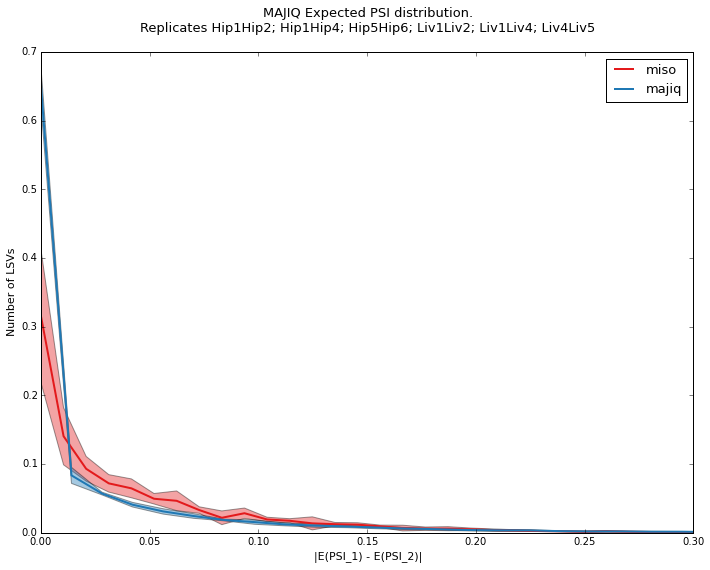

In [16]:
PLOTNAME = 'figure2A'
PLOTPATH = 'plots/'
plot_delta_expected_majiq_others(psis_diff_dict, args['rep_names'], plotpath=PLOTPATH, plotname=PLOTNAME)

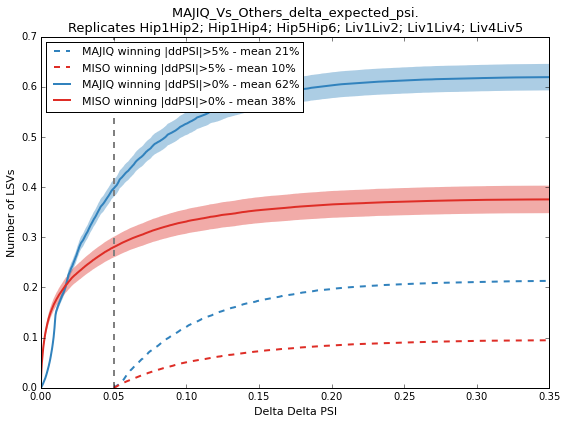

In [53]:
better_worse = []
for edx, ed in enumerate(psis_diff_dict['miso']):
    better_worse.append(ed-psis_diff_dict['majiq'][edx])
plot_delta_R({'miso': better_worse}, args['rep_names'], plotpath=PLOTPATH)

----
# Data for numbers quoted in MAJIQ paper

*Defining Ψ reproducibility as the difference between replicates (R(Ψ) = |E[Ψr1]-E[Ψr1]|) we found __81.2%__ of the junctions in quantifiable LSVs were reproducible within 5% (R(Ψ) < 5%, Fig2A)*

In [18]:
n_total_juncs = np.sum([dd.size for dd in psis_diff_dict['majiq']])
R_PSI_less_05 = np.sum([np.count_nonzero(dd <0.05) for dd in psis_diff_dict['majiq']])

print "%.1f%%" % (100*R_PSI_less_05/n_total_juncs)

81.2%


*Comparing MAJIQ to the commonly used MISO algorithm [] we found MAJIQ improved Ψ reproducibility for approximately two thirds of the LSVs (P(ΔR = RMISO-RMAJIQ)> 0 = __XX__%) and over two fold more showed a significant improvement (P(ΔR>0.05) = __21%__), P(ΔR< -0.05) = __10%__)*

In [19]:
n_majiq_win = np.sum([np.count_nonzero(dd < psis_diff_dict['miso'][idx]) for idx, dd in enumerate(psis_diff_dict['majiq'])])
print "%.1f%%" % (100*n_majiq_win/n_total_juncs)

61.7%


In [20]:
majiq_improved = np.sum([np.count_nonzero((psis_diff_dict['miso'][idx] - dd) >0.05) for idx, dd in enumerate(psis_diff_dict['majiq'])])
print "%.1f%%" % (100*majiq_improved/n_total_juncs)

21.2%


In [21]:
miso_improved = np.sum([np.count_nonzero((psis_diff_dict['miso'][idx] - dd) <-0.05) for idx, dd in enumerate(psis_diff_dict['majiq'])])
print "%.1f%%" % (100*miso_improved/n_total_juncs)

10.1%
